# Монетизация в обучающем игровом приложении

**Цель исследования:**

Анализ активности пользователей и основных продуктовых метрик обучающего игрового приложения.

**План исследования:**
- загрузка и первичный анализ данных,
- подготовка к исследовательскому анализу данных,
- исследовательский анализ данных:
    - Retention Rate,
    - время, проводимое в приложении,
    - распределение по уровням,
    - распределение платежей,
    - продуктовые метрики - ARPU, ARPPU, средний чек, среднее число покупок, конверсия.
- выводы.

**Описание данных:**

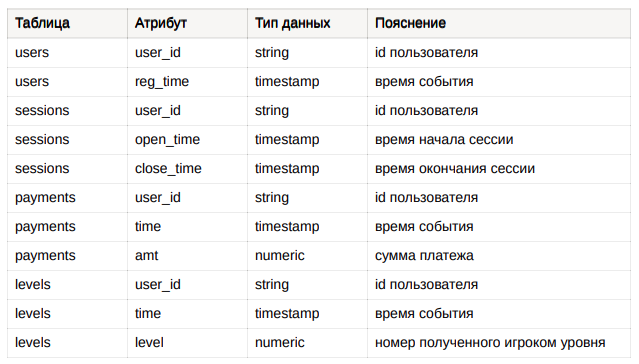

**Дополнительные вопросы:** 

**Вопрос №1.** В результате изменений в продукте ARPPU снизился. Это хорошо или плохо?

**Вопрос №2.** Предположим, что в результате обновления дизайна продукта вы наблюдаете увеличение среднего времени нахождения пользователей в приложении, но уровень конверсии в покупку снизился. Как вы будете анализировать данное изменение и какие рекомендации вы предложите команде продукта?

## Загрузка библиотек и данных, первичный анализ

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

from datetime import date, datetime, timedelta
import datetime as dt

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

### Таблица levels

In [2]:
levels = pd.read_csv('levels.csv').drop(columns=['Unnamed: 0'])
levels

,user_id,time,level
0,105194,2023-05-16 08:22:12.799003,2.0
1,105194,2023-05-16 08:26:42.405003,3.0
2,105194,2023-05-16 08:27:12.760003,4.0
3,991914,2023-05-16 09:06:38.315003,2.0
4,991914,2023-05-16 09:09:39.832003,3.0
...,...,...,...
130618,6906,2023-05-21 20:13:33.880003,5.0
130619,6906,2023-05-21 21:07:40.465003,6.0
130620,6906,2023-05-21 22:06:02.250002,7.0
130621,6906,2023-05-23 22:20:59.863003,8.0


"Родные" индексы были заданы непоследовательно. Пришлось удалить столбец.

In [3]:
levels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130623 entries, 0 to 130622
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  130623 non-null  int64  
 1   time     130623 non-null  object 
 2   level    130623 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.0+ MB


In [4]:
levels.duplicated().sum()

0

Пропусков нет, дубликатов нет. Изменим тип данных в колонке "time":

In [5]:
levels['time'] = pd.to_datetime(levels['time']).dt.floor('s')

In [6]:
levels['time'].describe()

count                  130623
unique                 115725
top       2023-05-16 02:15:12
freq                        7
first     2023-05-11 02:07:51
last      2023-05-30 16:58:43
Name: time, dtype: object

Самая ранняя дата в таблице: 2023-05-11 02:07:51. Самая поздняя: 2023-05-30 16:58:43.

In [7]:
print(f'Информация за период в {levels.time.max() - levels.time.min()}')

Информация за период в 19 days 14:50:52


In [8]:
print(f'Количество уникальных пользователей: {levels["user_id"].nunique()}')

Количество уникальных пользователей: 25545


In [9]:
levels['level'] = levels['level'].astype(int)

In [10]:
levels['level'].value_counts(normalize=True)

2     0.195479
3     0.163570
4     0.136745
5     0.110532
6     0.097448
7     0.092503
8     0.079060
9     0.050512
10    0.030883
11    0.020180
12    0.011889
13    0.006086
14    0.002940
15    0.001324
16    0.000567
17    0.000168
18    0.000054
19    0.000038
20    0.000015
21    0.000008
Name: level, dtype: float64

In [11]:
levels['level'].describe()

count    130623.000000
mean          5.128308
std           2.734426
min           2.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          21.000000
Name: level, dtype: float64

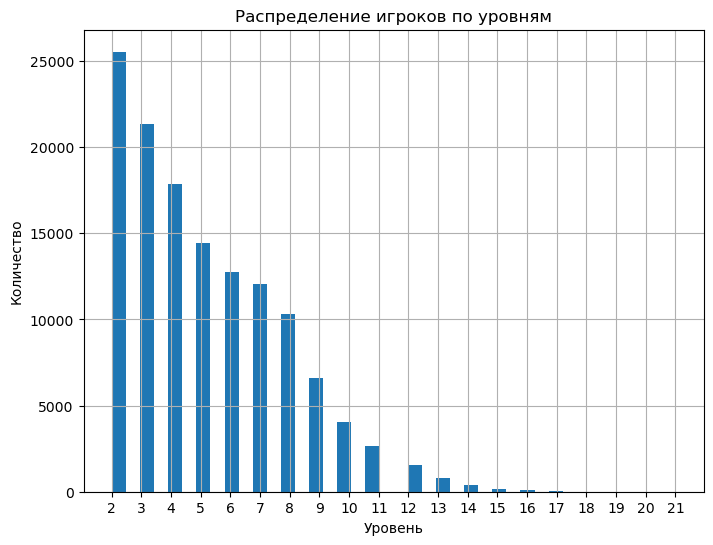

In [12]:
levels['level'].hist(figsize=(8, 6), bins=40)
plt.title('Распределение игроков по уровням')
plt.xlabel('Уровень')
plt.xticks(np.arange(2, 22))
plt.ylabel('Количество');

**Промежуточный вывод**

Таблица levels содержит 3 стобца и 130623 строки.</br>
Пропусков нет, дубликатов нет.</br>
Был изменен тип данных в колонке "time".</br>    
Самая ранняя дата в таблице: 2023-05-11 02:07:51. Самая поздняя: 2023-05-30 16:58:43. Информация охватывает период в 19 дней 14:50:52 часов.</br>
Количество уникальных пользователей, перешедших на 2 уровень и выше: 25545.</br>
Максимальный уровень в игре на момент анализа - 21-ый. Лишь 25% пользователей поднялись выше 7-го уровня.

Количество игроков, побывавших на первом уровне, по-видимому, равно количеству зарегистрировавшихся пользователей.

### Таблица payments

In [13]:
payments = pd.read_csv('payments.csv').drop(columns=['Unnamed: 0'])
payments

,user_id,pay_time,amt
0,107907,2023-05-29 17:08:18.890,0.400218
1,510991,2023-05-20 16:55:01.216,0.199608
2,294837,2023-05-19 01:41:55.970,0.199608
3,644287,2023-05-20 03:01:53.697,0.199608
4,673424,2023-05-20 03:33:36.918,0.099302
...,...,...,...
694,722621,2023-05-27 19:13:39.445,0.400218
695,940244,2023-05-19 03:08:36.320,0.400218
696,895621,2023-05-22 20:50:28.787,3.008157
697,940244,2023-05-23 15:52:14.721,1.503577


"Родные" индексы были заданы непоследовательно. Пришлось удалить столбец.

In [14]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   699 non-null    int64  
 1   pay_time  699 non-null    object 
 2   amt       699 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 16.5+ KB


In [15]:
payments.duplicated().sum()

0

Пропусков нет, дубликатов нет. Поменяем тип в столбце "pay_time":

In [16]:
payments['pay_time'] = pd.to_datetime(payments['pay_time']).dt.floor('s')

In [17]:
payments['pay_time'].describe()

count                     699
unique                    699
top       2023-05-29 17:08:18
freq                        1
first     2023-05-12 11:01:31
last      2023-05-30 04:11:03
Name: pay_time, dtype: object

Первый платеж: 2023-05-12 11:01:31. Последний платеж: 2023-05-30 04:11:03.

In [18]:
print(f'Платежный период в датасете: {payments.pay_time.max() - payments.pay_time.min()}')

Платежный период в датасете: 17 days 17:09:32


In [19]:
payments['amt'].describe()

count    699.000000
mean       0.717320
std        1.043477
min        0.099302
25%        0.199608
50%        0.400218
75%        1.002050
max       10.029531
Name: amt, dtype: float64

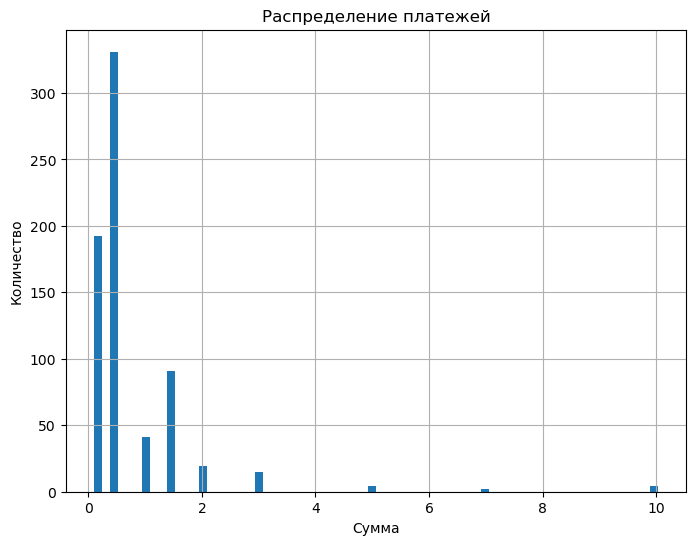

In [20]:
payments['amt'].hist(figsize=(8, 6), bins=70)
plt.title('Распределение платежей')
plt.xlabel('Сумма')
plt.ylabel('Количество');

In [21]:
payments['amt'].value_counts(normalize=True)

0.400218     0.473534
0.199608     0.207439
1.503577     0.130186
0.099302     0.067239
1.002050     0.058655
2.004101     0.027182
3.008157     0.021459
10.029531    0.005722
5.014264     0.005722
7.019368     0.002861
Name: amt, dtype: float64

In [22]:
payments['amt'].value_counts(bins=5)

(0.08839999999999999, 2.085]    674
(2.085, 4.071]                   15
(4.071, 6.057]                    4
(8.043, 10.03]                    4
(6.057, 8.043]                    2
Name: amt, dtype: int64

In [23]:
print(f'Количество уникальных пользователей: {payments["user_id"].nunique()}')

Количество уникальных пользователей: 312


**Промежуточный вывод**

Датасет содержит 3 столбца и 699 строк.</br>
Пропусков нет, дубликатов нет.</br>
Был изменен тип данных в колонке "pay_time".</br>

Первый платеж: 2023-05-12 11:01:31. Последний платеж: 2023-05-30 04:11:03. Платежный период в датасете: 17 days 17:09:32.</br>
Всего 10 видов платежей. Лишь 25% крупнее 1 доллара. 674 платежа из 699 не превышают 2.1 доллара.</br>
В датасете информация о покупках 312 пользователей.

### Таблица sessions

In [24]:
sessions = pd.read_csv('sessions.csv').drop(columns=['Unnamed: 0'])
sessions

,user_id,close_time,open_time
0,875013,2023-05-16 05:17:59,2023-05-16 05:06:09
1,138278,2023-05-16 06:48:24,2023-05-16 06:47:34
2,138278,2023-05-18 01:44:40,2023-05-18 01:07:58
3,138278,2023-05-18 05:02:58,2023-05-18 04:51:06
4,138278,2023-05-19 05:58:32,2023-05-19 05:46:19
...,...,...,...
357999,588542,2023-05-12 08:17:44,2023-05-12 08:17:22
358000,588542,2023-05-12 09:59:02,2023-05-12 09:52:20
358001,588542,2023-05-12 13:47:16,2023-05-12 13:45:02
358002,588542,2023-05-12 14:22:15,2023-05-12 14:21:32


"Родные" индексы были заданы непоследовательно. Пришлось удалить столбец.

In [25]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358004 entries, 0 to 358003
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     358004 non-null  int64 
 1   close_time  358004 non-null  object
 2   open_time   358004 non-null  object
dtypes: int64(1), object(2)
memory usage: 8.2+ MB


In [26]:
sessions.duplicated().sum()

0

Пропусков нет, дубликатов нет. Изменим тип данных в столбцах с датами:

In [27]:
print(f'Количество уникальных пользователей: {sessions["user_id"].nunique()}')

Количество уникальных пользователей: 31070


In [28]:
sessions['close_time'] = pd.to_datetime(sessions['close_time'])
sessions['open_time'] = pd.to_datetime(sessions['open_time'])

In [29]:
sessions[['open_time', 'close_time']].describe()

,open_time,close_time
count,358004,358004
unique,299246,294281
top,2023-05-18 10:51:42,2023-05-18 10:35:26
freq,9,627
first,2023-05-11 02:01:37,2023-05-11 02:05:06
last,2023-05-30 17:09:26,2023-05-30 17:18:17


In [30]:
print(f'Сессии охватывают период в: {sessions.close_time.max() - sessions.open_time.min()}')

Сессии охватывают период в: 19 days 15:16:40


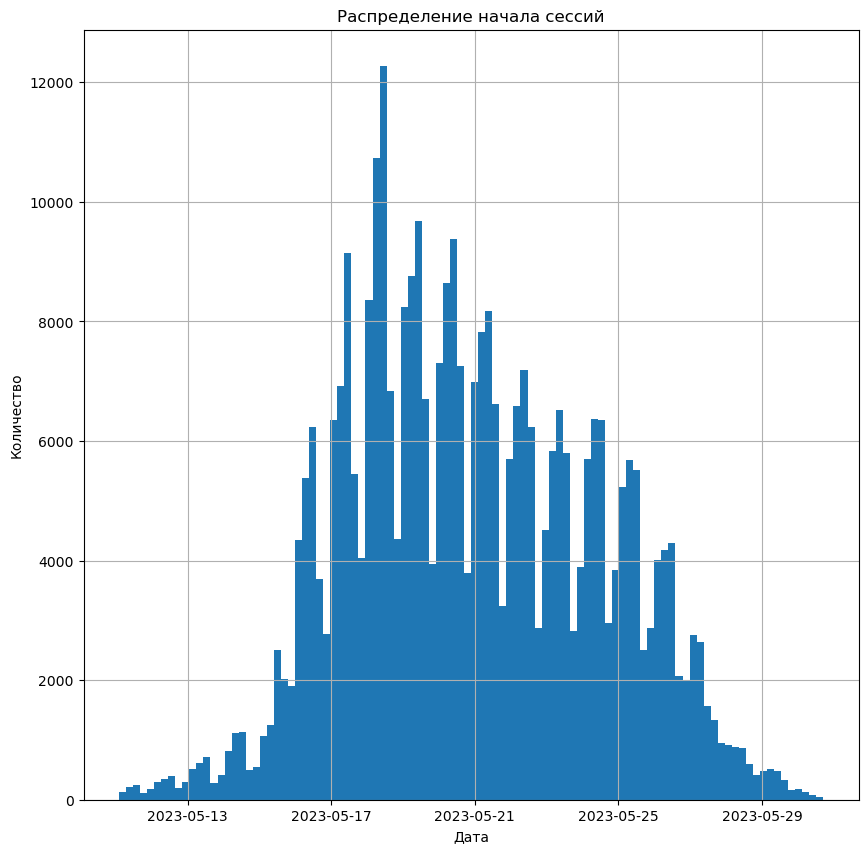

In [31]:
sessions['open_time'].hist(figsize=(10, 10), bins=100)
plt.title('Распределение начала сессий')
plt.xlabel('Дата')
plt.ylabel('Количество');

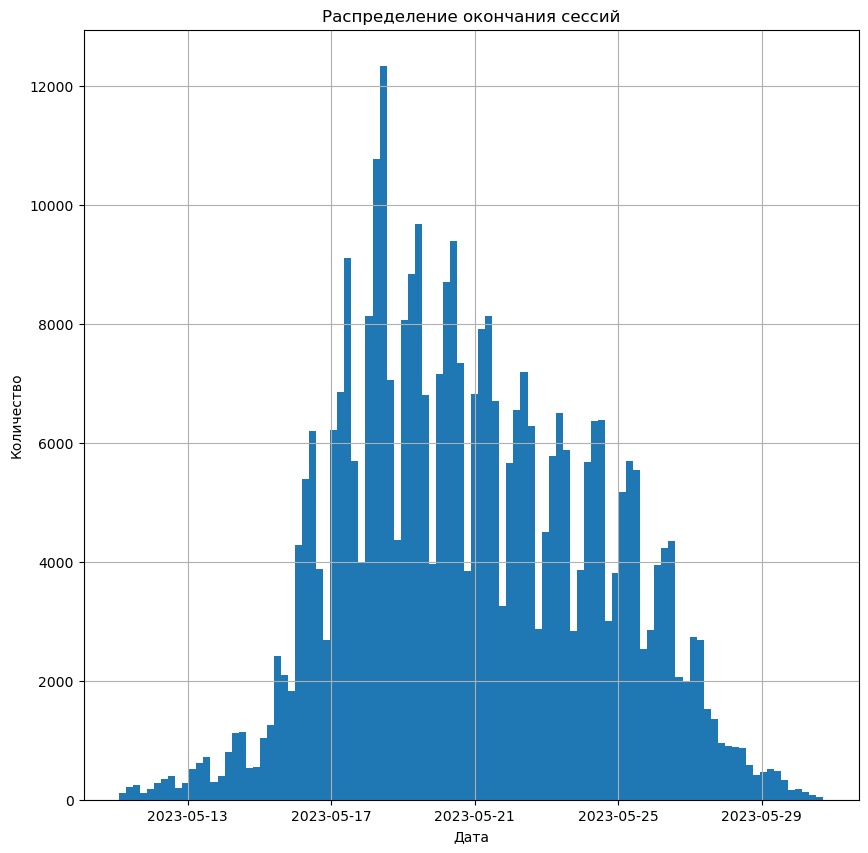

In [32]:
sessions['close_time'].hist(figsize=(10, 10), bins=100)
plt.title('Распределение окончания сессий')
plt.xlabel('Дата')
plt.ylabel('Количество');

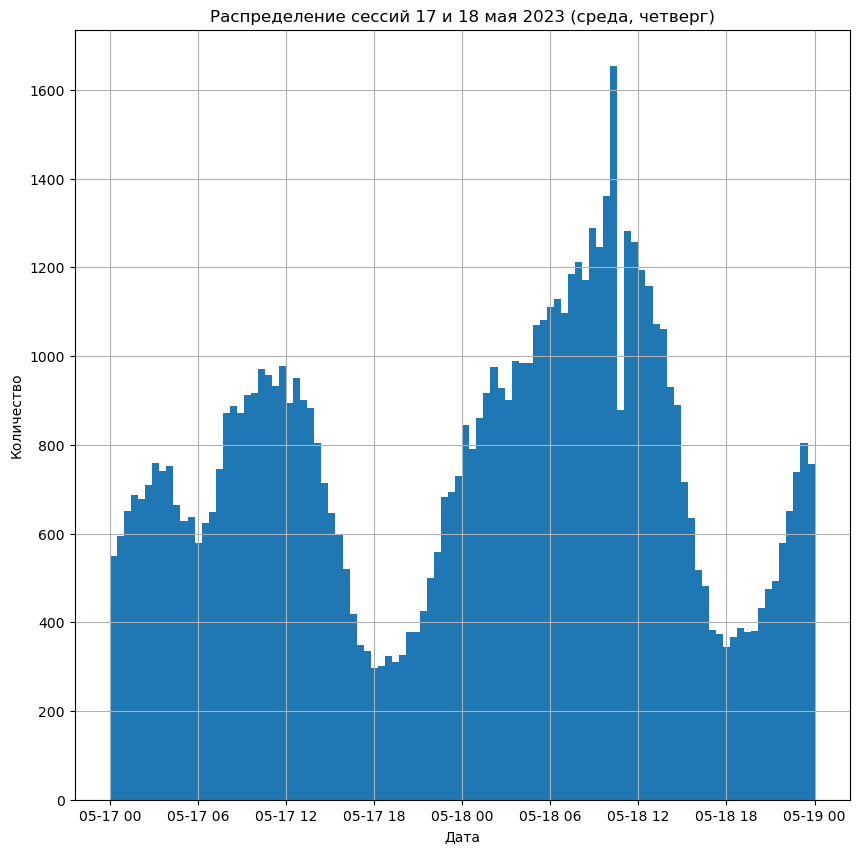

In [33]:
sessions['open_time'].hist(figsize=(10, 10), bins=100, range=('2023-05-17 00:00:00', '2023-05-19 00:00:00'))
plt.title('Распределение сессий 17 и 18 мая 2023 (среда, четверг)')
plt.xlabel('Дата')
plt.ylabel('Количество');

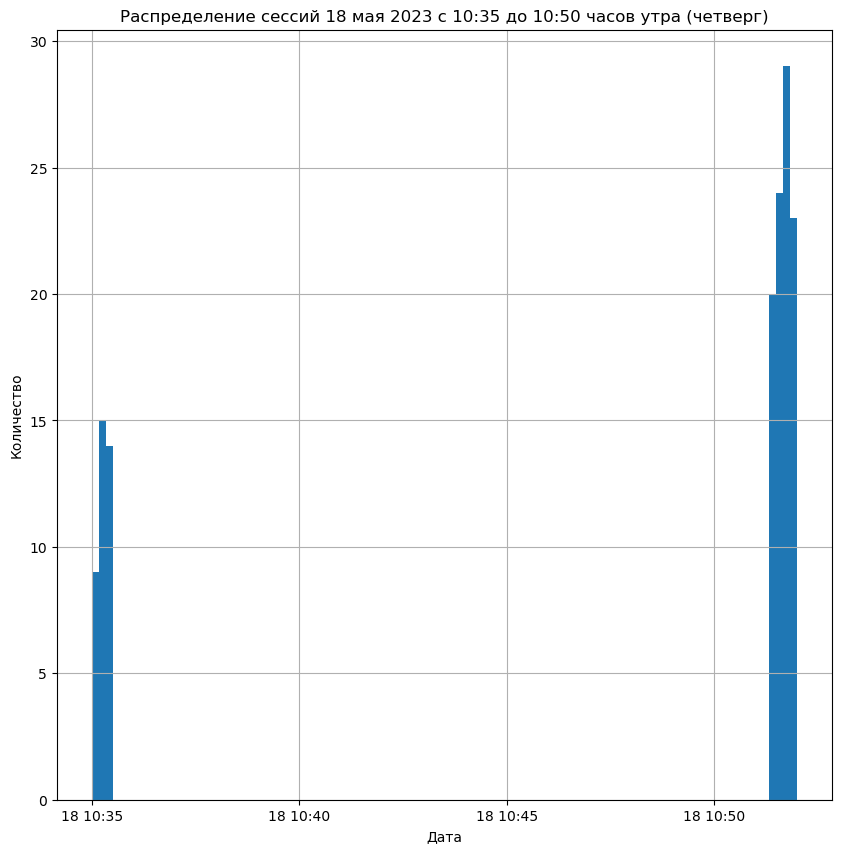

In [34]:
sessions['open_time'].hist(figsize=(10, 10), bins=100, range=('2023-05-18 10:35:00', '2023-05-18 10:52:00'))
plt.title('Распределение сессий 18 мая 2023 с 10:35 до 10:50 часов утра (четверг)')
plt.xlabel('Дата')
plt.ylabel('Количество');

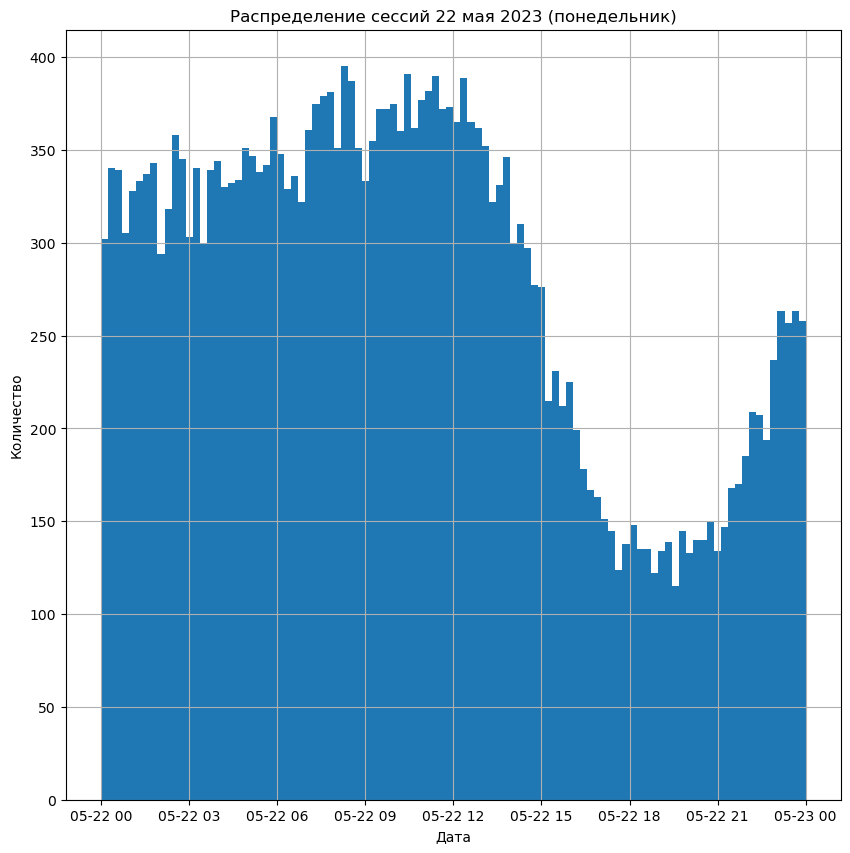

In [35]:
sessions['open_time'].hist(figsize=(10, 10), bins=100, range=('2023-05-22 00:00:00', '2023-05-23 00:00:00'))
plt.title('Распределение сессий 22 мая 2023 (понедельник)')
plt.xlabel('Дата')
plt.ylabel('Количество');

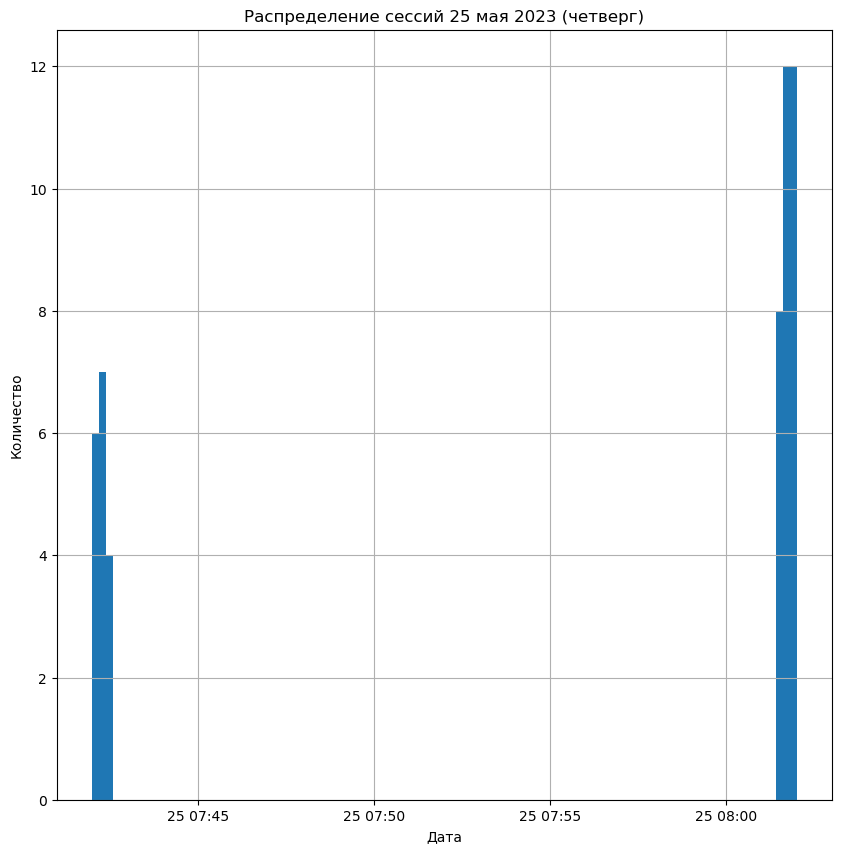

In [36]:
sessions['open_time'].hist(figsize=(10, 10), bins=100, range=('2023-05-25 07:42:00', '2023-05-25 08:02:00'))
plt.title('Распределение сессий 25 мая 2023 (четверг)')
plt.xlabel('Дата')
plt.ylabel('Количество');

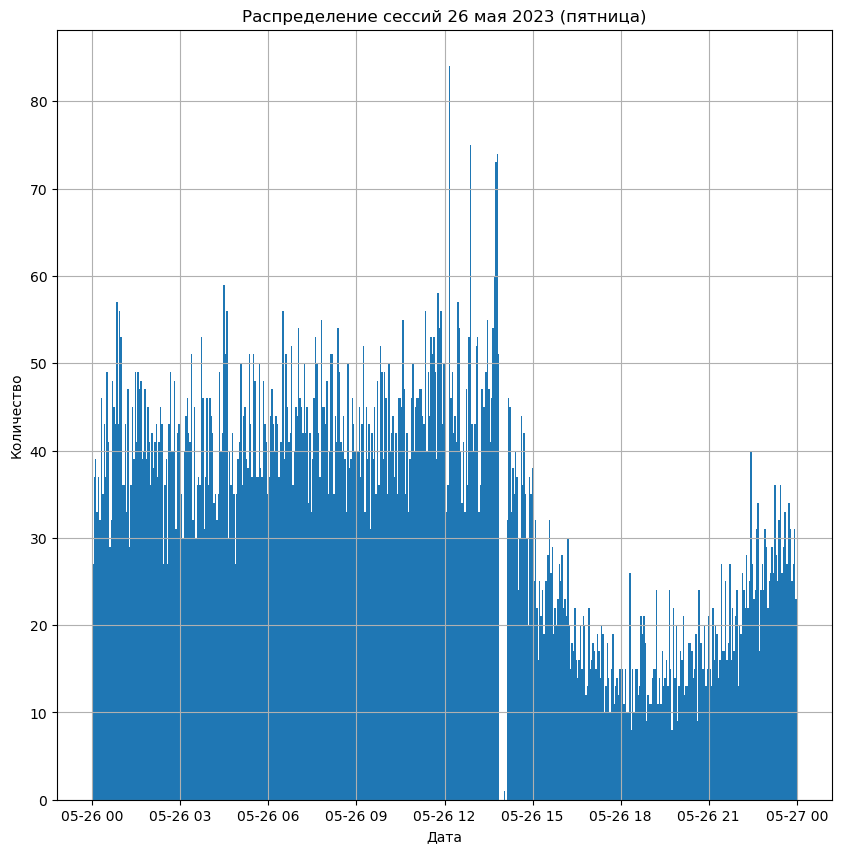

In [37]:
sessions['open_time'].hist(figsize=(10, 10), bins=500, range=('2023-05-26 00:00:00', '2023-05-27 00:00:00'))
plt.title('Распределение сессий 26 мая 2023 (пятница)')
plt.xlabel('Дата')
plt.ylabel('Количество');

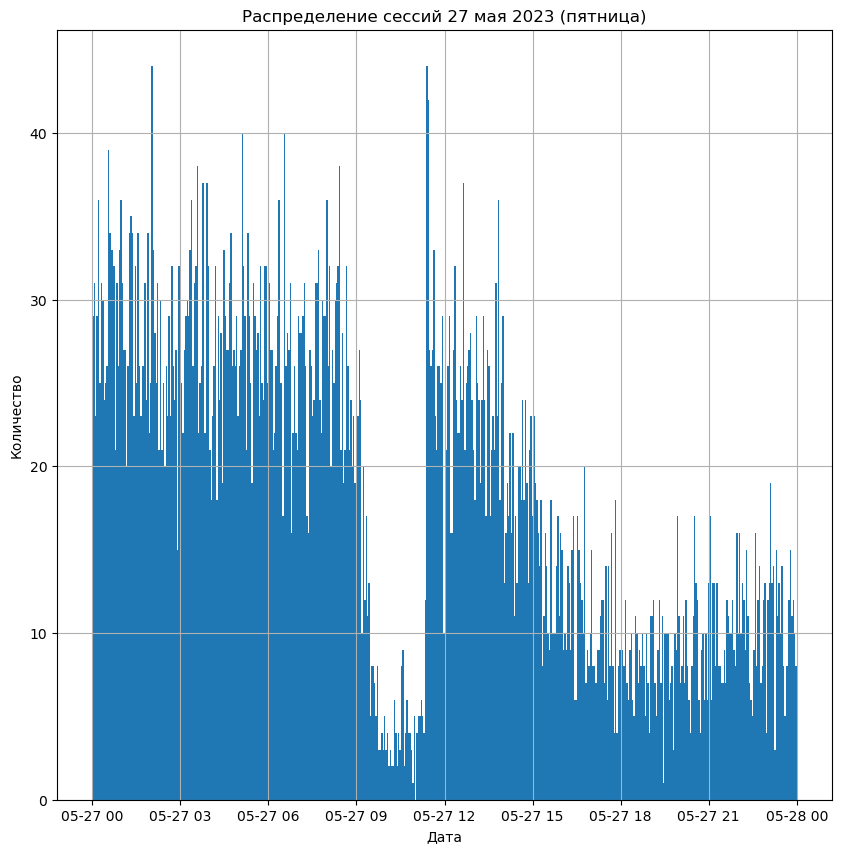

In [38]:
sessions['open_time'].hist(figsize=(10, 10), bins=500, range=('2023-05-27 00:00:00', '2023-05-28 00:00:00'))
plt.title('Распределение сессий 27 мая 2023 (пятница)')
plt.xlabel('Дата')
plt.ylabel('Количество');

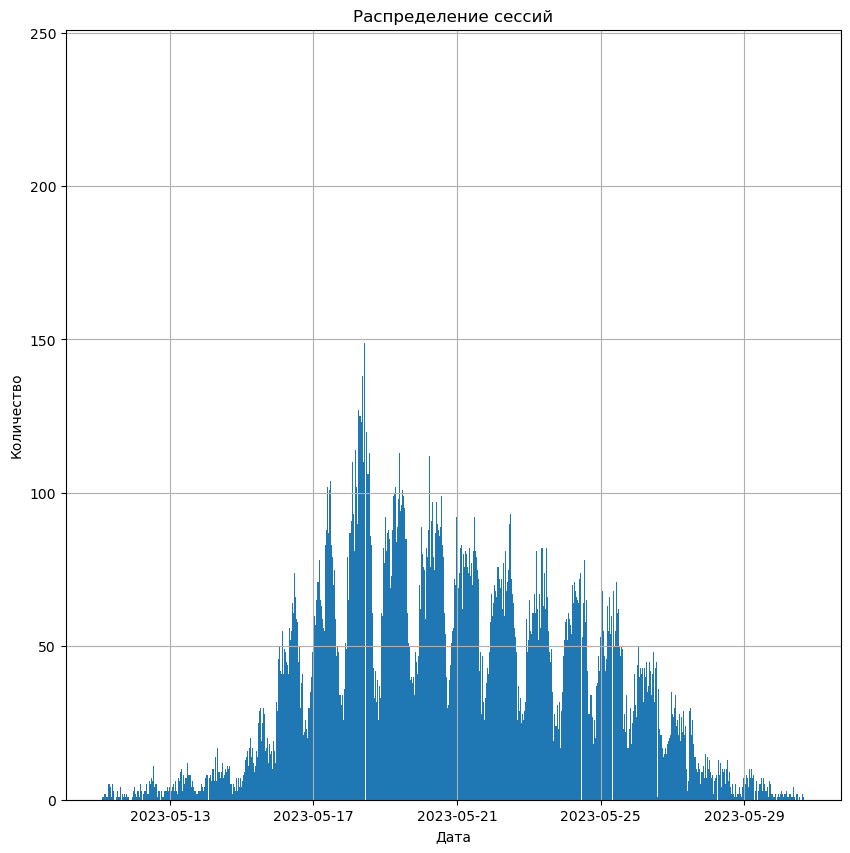

In [39]:
sessions['open_time'].hist(figsize=(10, 10), bins=10000)
plt.title('Распределение сессий')
plt.xlabel('Дата')
plt.ylabel('Количество');

**Промежуточный вывод**

Датасет содержит 3 столбца и 358004 строк.</br>
В нем представлена информация о сессиях 31070 пользователей.</br>
Пропусков нет, дубликатов нет, был изменен тип данных в столбцах с датами.

Сессии охватывают период в: 19 days 15:16:40, начиная с 11 мая и заканчивая 30 мая 2023 года.

В начале и конце исследуемого периода небольшое количество сессий. Похоже на результат рекламной кампании. Пик приходится на 18 мая, четверг. Не заметно влияния выходных. В течение дня пик приходится на первую половину дня (до 12 часов), спад - на 18:00 (окончание рабочего дня?).

Возможно наличие проблем с доступностью - 18 мая примерно с 10:35 до 10:50 не было посетителей. Точно так же 25 мая (четверг) утром в течение 15 минут не было посетителей (около 8 часов утра). Есть провал 26 мая (в районе 2 часов дня) и 27 мая (около 11 утра). Видны длительные "пробелы" 14 и 24 мая.

### Таблица users

In [40]:
users = pd.read_csv('users.csv').drop(columns=['Unnamed: 0'])
users

,user_id,reg_time
0,439127,2023-05-16 15:47:56.024
1,646681,2023-05-16 16:32:35.495
2,35136,2023-05-16 16:50:14.571
3,933255,2023-05-16 03:28:56.790
4,59440,2023-05-16 06:53:22.412
...,...,...
31109,119441,2023-05-19 14:34:17.862
31110,90641,2023-05-19 21:44:34.158
31111,152066,2023-05-20 01:26:42.802
31112,740216,2023-05-20 08:49:46.198


In [41]:
users['user_id'].nunique()

31114

In [42]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31114 entries, 0 to 31113
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   31114 non-null  int64 
 1   reg_time  31114 non-null  object
dtypes: int64(1), object(1)
memory usage: 486.3+ KB


In [43]:
users['reg_time'] = pd.to_datetime(users['reg_time']).dt.floor('s')

In [44]:
users['reg_time'].describe()

count                   31114
unique                  29826
top       2023-05-17 13:35:26
freq                        5
first     2023-05-11 02:01:36
last      2023-05-21 01:58:09
Name: reg_time, dtype: object

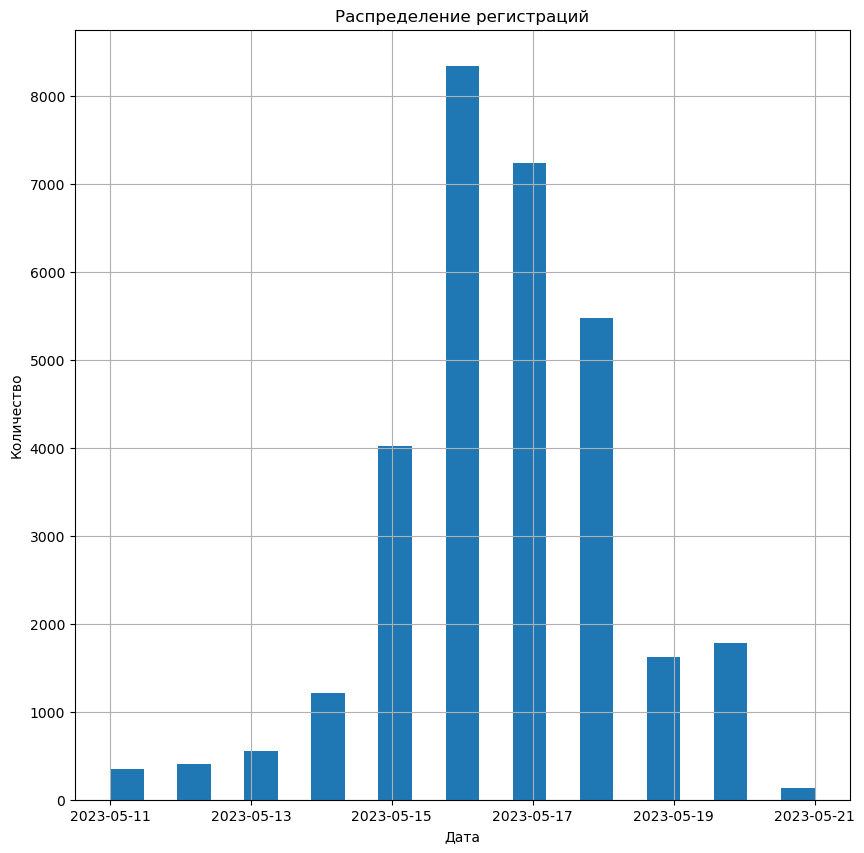

In [45]:
users['reg_time'].dt.date.hist(figsize=(10, 10), bins=21)
plt.title('Распределение регистраций')
plt.xlabel('Дата')
plt.ylabel('Количество');

**Промежуточный вывод**

Таблица users представляет собой информацию о датaх регистрации 31114 пользователей.</br>
Пропусков нет, дубликатов нет.</br>
Не все зарегистрированные пользователи заходили в приложение в исследуемый период. В логах сессий всего лишь 31070 пользователей, следовательно, 44 человека зарегистрировались, но не совершали действий. В таблице "levels" 25545 уникальных пользователей. Значит, 5525 пользователей в данный момент находятся на 1 уровне.</br>
У дат регистрации близкое к нормальному распределение, пик - 16 мая 2023 года. Период: с 11 по 21 мая 2023 года.

## Подготовка к анализу данных

Первичное знакомство с данными позволяет сделать следующие выводы по таблицам:

- Уровни с 11 по 30 мая (25545 уников)
- Платежи с 12 по 30 мая (312 уников)
- Сессии с 11 по 30 мая (31070 уников)
- Регистрации с 11 по 21 мая (31114 уников)

Проверим пересечение пользователей между таблицами.

In [46]:
u_s_intersect_1 = list(np.intersect1d(users['user_id'], sessions['user_id']))
print(f'Количество зарегистрированных пользователей, присутствующих в логах: {len(u_s_intersect_1)}')

Количество зарегистрированных пользователей, присутствующих в логах: 31070


In [47]:
u_p_intersect_1 = list(np.intersect1d(users['user_id'], payments['user_id']))
print(f'Количество зарегистрированных пользователей среди плательщиков: {len(u_p_intersect_1)}')

Количество зарегистрированных пользователей среди плательщиков: 312


In [48]:
u_l_intersect_1 = list(np.intersect1d(users['user_id'], levels['user_id']))
print(f'Количество зарегистрированных пользователей, перешедших на уровни выше: {len(u_l_intersect_1)}')

Количество зарегистрированных пользователей, перешедших на уровни выше: 25545


В таблицах содержится информация только о пользователях, прошедших регистрацию с 11 по 21 мая. Однако есть разница в 44 человека между зарегистрированными и активными пользователями.

In [49]:
active_users = list(sessions['user_id'].unique())

In [50]:
users.query('user_id not in @active_users')

,user_id,reg_time
1896,629905,2023-05-16 15:32:51
4545,661898,2023-05-18 08:32:24
7268,815414,2023-05-17 07:41:40
10995,117206,2023-05-17 04:21:31
11107,637623,2023-05-17 22:10:49
12004,814028,2023-05-16 14:28:32
12115,130554,2023-05-19 23:06:17
12116,598881,2023-05-15 10:46:07
14226,36662,2023-05-15 21:25:44
14998,932753,2023-05-17 10:31:14


In [51]:
levels.query('user_id not in @active_users')

,user_id,time,level
21030,620201,2023-05-16 02:09:52,2


In [52]:
payments.query('user_id not in @active_users')

,user_id,pay_time,amt


In [53]:
print(f'Доля неактивных пользователей в процентах:\
      {(100 * len(users.query("user_id not in @active_users")) / len(active_users))}')

Доля неактивных пользователей в процентах:      0.14161570646926294


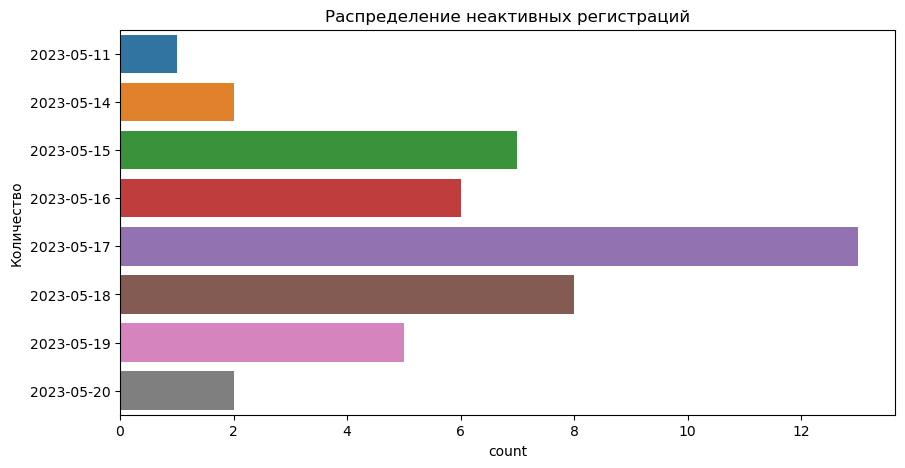

In [54]:
plt.figure(figsize=(10, 5))
sns.countplot(data=users.query('user_id not in @active_users'), 
              y=users.query('user_id not in @active_users')['reg_time'].dt.date.sort_values())
plt.title('Распределение неактивных регистраций')
plt.ylabel('Дата')
plt.ylabel('Количество');

Доля неактивных пользователей - меньше 1 процента, их распределение совпадает с распределением регистраций. Удалим их из датасетов, так как они бесполезны для нашего исследования.

In [55]:
users = users.query('user_id in @active_users')

In [56]:
levels = levels.query('user_id in @active_users')

In [57]:
users.shape[0]

31070

In [58]:
levels.shape[0]

130622

In [59]:
levels['user_id'].nunique()

25544

**Вывод**

После удаления неактивных пользователей данные представляют собой следующее:

- Уровни - 25 544 уника
- Платежи  - 312 уников
- Сессии - 31 070 уников
- Регистрации - 31 070 уников

## Исследовательский анализ данных

### Время, которое пользователи проводят в приложении

Рассчитаем длительность сессий

In [60]:
sessions['session_duration'] = (sessions['close_time'] - sessions['open_time']).dt.total_seconds()

In [61]:
sessions

,user_id,close_time,open_time,session_duration
0,875013,2023-05-16 05:17:59,2023-05-16 05:06:09,710.0
1,138278,2023-05-16 06:48:24,2023-05-16 06:47:34,50.0
2,138278,2023-05-18 01:44:40,2023-05-18 01:07:58,2202.0
3,138278,2023-05-18 05:02:58,2023-05-18 04:51:06,712.0
4,138278,2023-05-19 05:58:32,2023-05-19 05:46:19,733.0
...,...,...,...,...
357999,588542,2023-05-12 08:17:44,2023-05-12 08:17:22,22.0
358000,588542,2023-05-12 09:59:02,2023-05-12 09:52:20,402.0
358001,588542,2023-05-12 13:47:16,2023-05-12 13:45:02,134.0
358002,588542,2023-05-12 14:22:15,2023-05-12 14:21:32,43.0


In [62]:
sessions['session_duration'].describe()

count    358004.000000
mean        750.621099
std        1171.167304
min           0.000000
25%         156.000000
50%         419.000000
75%         920.000000
max       81916.000000
Name: session_duration, dtype: float64

Между средней и медианной длительностью сессии большая разница - 750 и 419 секунд соответственно. В таблице есть сессии длительностью 0 секунд. Максимальная сессия - 81916 (почти 23 часа).

In [63]:
sessions.query('session_duration == 81916')

,user_id,close_time,open_time,session_duration
339681,951625,2023-05-26 11:59:09,2023-05-25 13:13:53,81916.0


In [64]:
levels.query('user_id == 951625')

,user_id,time,level
123181,951625,2023-05-20 14:22:59,2
123182,951625,2023-05-20 17:09:56,3
123183,951625,2023-05-20 18:06:26,4
123184,951625,2023-05-21 00:21:22,5
123185,951625,2023-05-21 03:32:19,6
123186,951625,2023-05-21 06:01:46,7
123187,951625,2023-05-21 14:43:39,8
123188,951625,2023-05-25 15:30:51,9
123189,951625,2023-05-25 18:32:46,10
123190,951625,2023-05-26 06:58:10,11


Пользователь с id 951625 провел почти 23 часа в приложении, пройдя за это время 8-10 уровни.

In [65]:
sessions.query('session_duration == 0').sort_values(by='open_time', ascending=True)

,user_id,close_time,open_time,session_duration
348275,716327,2023-05-11 03:36:44,2023-05-11 03:36:44,0.0
146167,579684,2023-05-11 05:59:41,2023-05-11 05:59:41,0.0
81271,572423,2023-05-11 07:14:17,2023-05-11 07:14:17,0.0
337506,427642,2023-05-11 07:15:11,2023-05-11 07:15:11,0.0
81272,572423,2023-05-11 08:14:53,2023-05-11 08:14:53,0.0
...,...,...,...,...
182090,333892,2023-05-29 04:08:52,2023-05-29 04:08:52,0.0
294661,526945,2023-05-29 05:10:43,2023-05-29 05:10:43,0.0
108609,88177,2023-05-29 06:04:35,2023-05-29 06:04:35,0.0
357183,253817,2023-05-29 06:36:36,2023-05-29 06:36:36,0.0


2648 сессий имеют длительность 0 секунд. Вероятно, это вызвано техническими проблемами. Количество таких записей - меньше 1%, удалим их.

In [66]:
sessions = sessions.query('session_duration != 0')

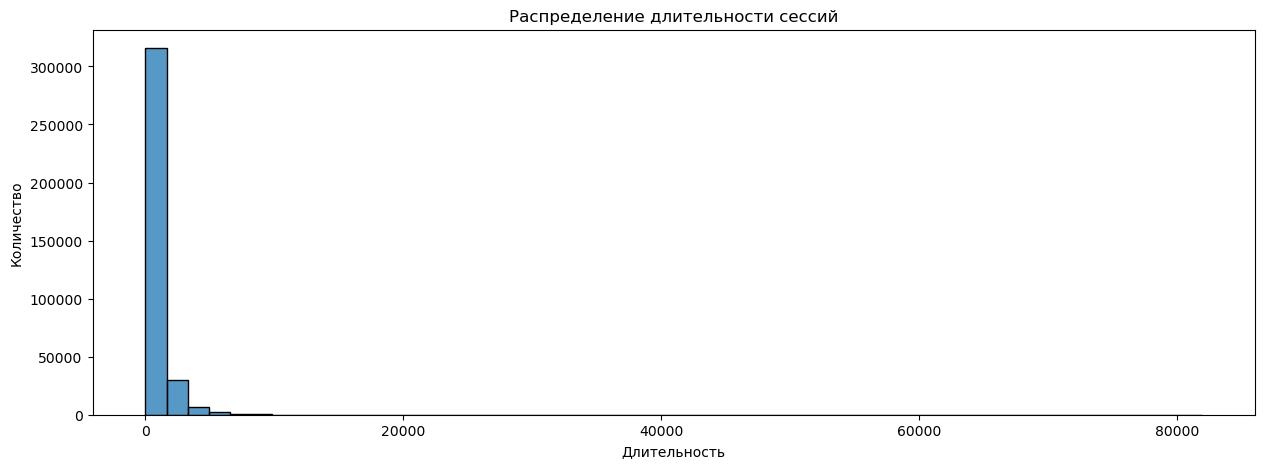

In [67]:
plt.figure(figsize=(15, 5))
sns.histplot(sessions, x='session_duration', bins=50)
plt.title('Распределение длительности сессий')
plt.ylabel('Количество')
plt.xlabel('Длительность')
plt.show();

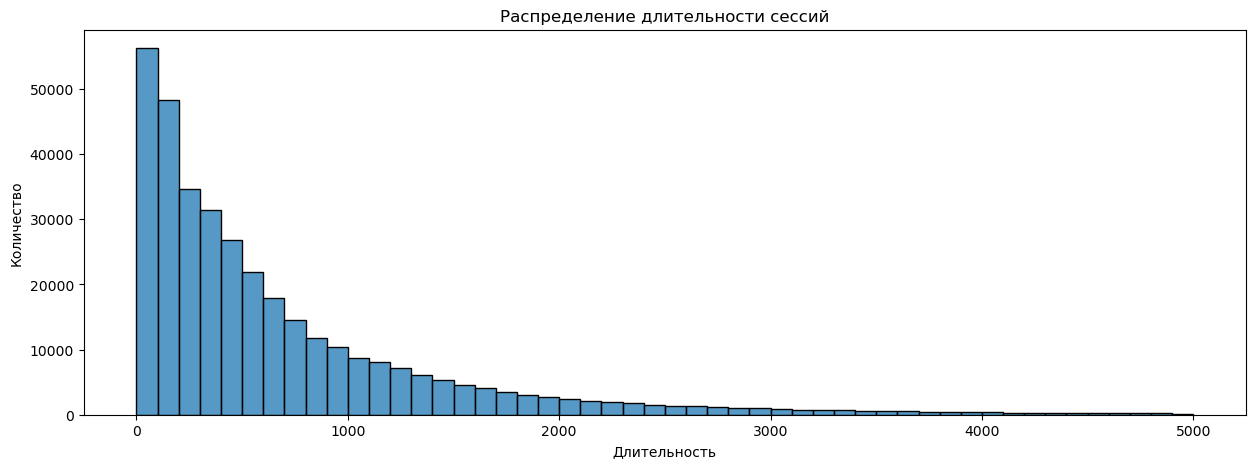

In [68]:
plt.figure(figsize=(15, 5))
sns.histplot(sessions, x='session_duration', bins=50, binrange=(0, 5000))
plt.title('Распределение длительности сессий')
plt.ylabel('Количество')
plt.xlabel('Длительность')
plt.show();

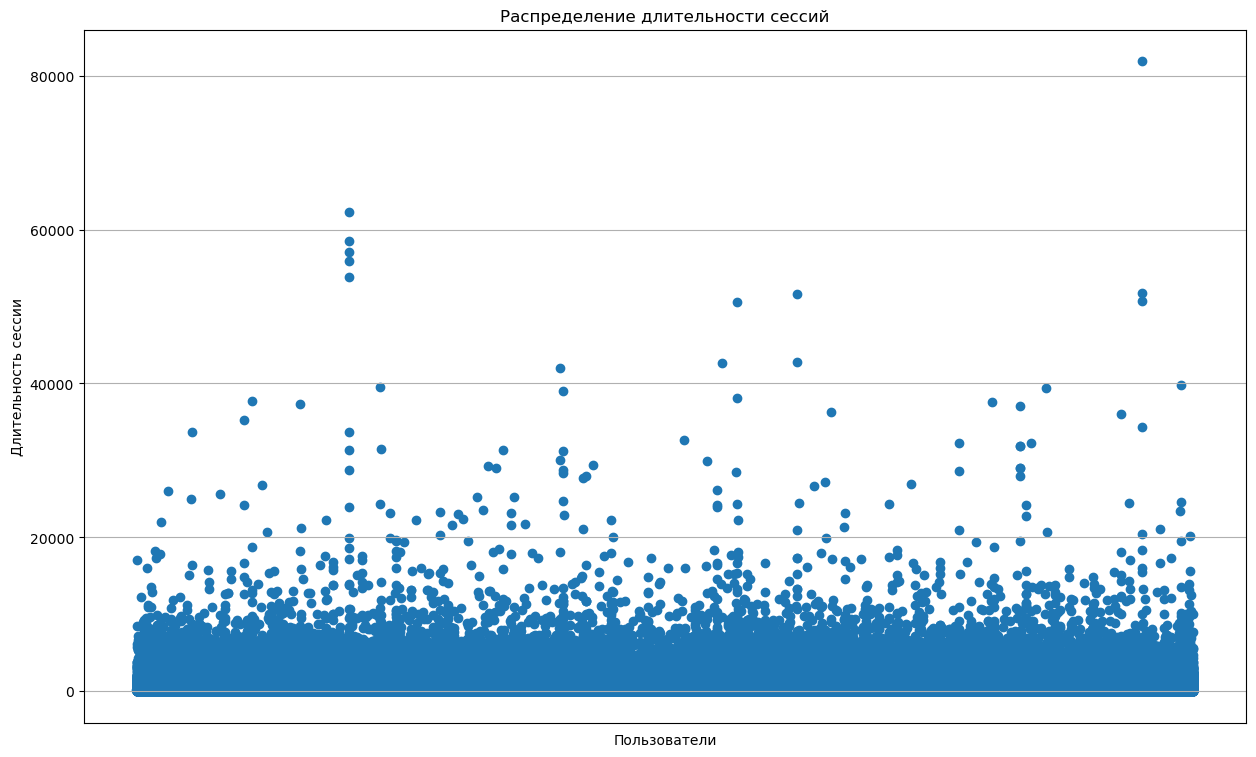

In [69]:
plt.figure(figsize = (15, 9))
plt.title('Распределение длительности сессий')
plt.grid(True)
plt.xlabel('Пользователи')
plt.ylabel('Длительность сессии')
plt.scatter(sessions['user_id'], sessions['session_duration'])
plt.xticks([]); 

Очевидно наличие аномалий. Максимальная длительность сессии составляет 81916 секунд (почти 23 часа).

In [70]:
np.percentile(sessions['session_duration'], [95, 99])

array([2518.25, 4929.  ])

99 процентиль составляет 4929 секунд. Обрежем наши данные, удалив 1% сессий со слишком большой длительностью.

In [71]:
top_value = np.percentile(sessions['session_duration'], [99])
100 * sessions.query(('session_duration <= @top_value')).shape[0] / sessions.shape[0]

99.00072040432693

In [72]:
sessions_cleaned = sessions.query('session_duration <= @top_value')
sessions_cleaned

,user_id,close_time,open_time,session_duration
0,875013,2023-05-16 05:17:59,2023-05-16 05:06:09,710.0
1,138278,2023-05-16 06:48:24,2023-05-16 06:47:34,50.0
2,138278,2023-05-18 01:44:40,2023-05-18 01:07:58,2202.0
3,138278,2023-05-18 05:02:58,2023-05-18 04:51:06,712.0
4,138278,2023-05-19 05:58:32,2023-05-19 05:46:19,733.0
...,...,...,...,...
357999,588542,2023-05-12 08:17:44,2023-05-12 08:17:22,22.0
358000,588542,2023-05-12 09:59:02,2023-05-12 09:52:20,402.0
358001,588542,2023-05-12 13:47:16,2023-05-12 13:45:02,134.0
358002,588542,2023-05-12 14:22:15,2023-05-12 14:21:32,43.0


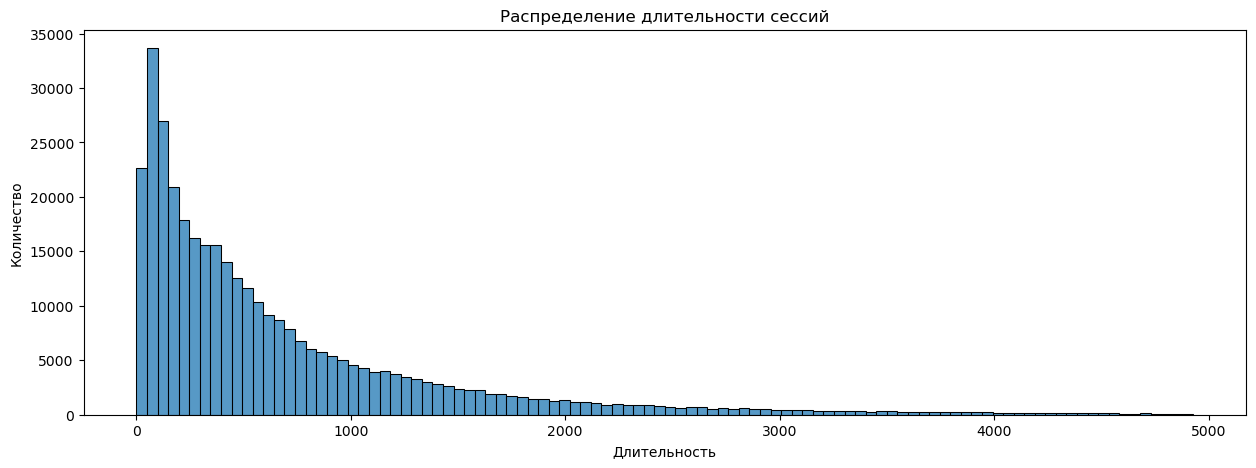

In [73]:
plt.figure(figsize=(15, 5))
sns.histplot(sessions_cleaned, x='session_duration', bins=100)
plt.title('Распределение длительности сессий')
plt.ylabel('Количество')
plt.xlabel('Длительность')
plt.show();

In [74]:
sessions_cleaned['session_duration'].describe()

count    351805.000000
mean        683.390452
std         772.673267
min           1.000000
25%         159.000000
50%         417.000000
75%         902.000000
max        4929.000000
Name: session_duration, dtype: float64

На очищенных данных среднее время сессии составляет 683 секунды (около 11 минут), а медианное - 417 секунд (примерно 7 минут).

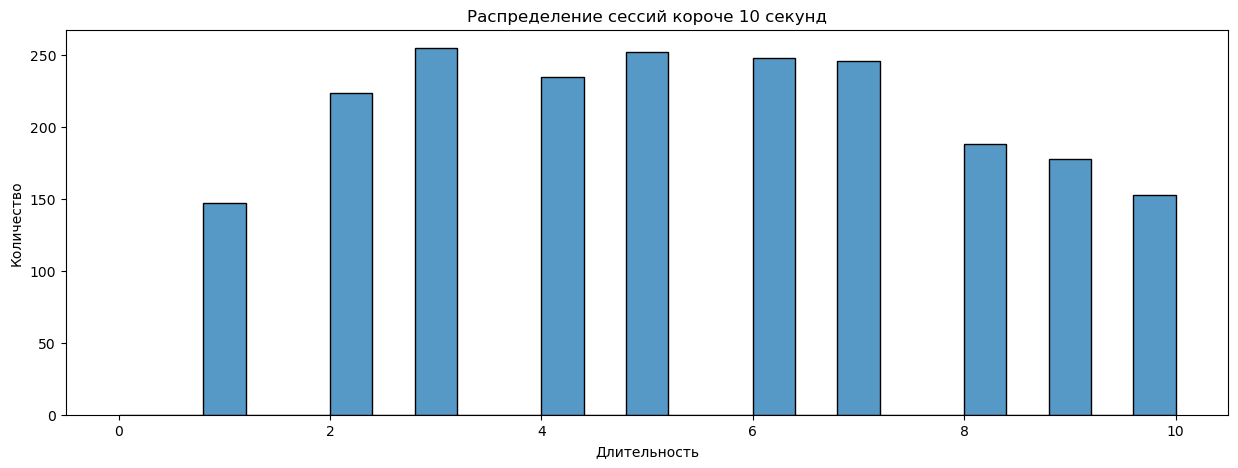

In [75]:
plt.figure(figsize=(15, 5))
sns.histplot(sessions_cleaned, x='session_duration', bins=25, binrange=(0, 10))
plt.title('Распределение сессий короче 10 секунд')
plt.ylabel('Количество')
plt.xlabel('Длительность')
plt.show();

In [76]:
sessions_cleaned.query('session_duration <= 10')

,user_id,close_time,open_time,session_duration
426,22457,2023-05-18 11:32:37,2023-05-18 11:32:33,4.0
504,630131,2023-05-22 11:41:01,2023-05-22 11:40:51,10.0
820,995802,2023-05-16 00:51:27,2023-05-16 00:51:20,7.0
886,234513,2023-05-25 07:42:23,2023-05-25 07:42:13,10.0
1007,946590,2023-05-23 10:13:05,2023-05-23 10:12:56,9.0
...,...,...,...,...
356952,201119,2023-05-17 08:49:24,2023-05-17 08:49:22,2.0
356960,201119,2023-05-22 03:16:32,2023-05-22 03:16:29,3.0
357185,841765,2023-05-19 18:02:23,2023-05-19 18:02:22,1.0
357195,947973,2023-05-26 18:05:34,2023-05-26 18:05:28,6.0


Больше 2 тысяч сессий короче 10 секунд. Возможно, пользователи заходят в приложение, чтобы было зафиксировано ежедневное посещение. Это важно, например, в том случае, если предусмотрены бонусы за ежедневные занятия. Оставим эти сессии.

**Промежуточный вывод**

Среднее время сессии составляет 683 секунды (около 11 минут), а медианное - 417 секунд (примерно 7 минут). Распределение длительности сессий убывает по экспоненциальному закону. 

Из данных были исключены сессии длиной 0 секунд и 1% аномально долгих сессий (максимальная - почти 23 часа).

### Как пользователи переходят с уровня на уровень

Посмотрим, за какое время игрок переходит от уровня к уровню

In [77]:
level_with_reg = levels.merge(users, on='user_id')
level_with_reg

,user_id,time,level,reg_time
0,105194,2023-05-16 08:22:12,2,2023-05-16 08:19:17
1,105194,2023-05-16 08:26:42,3,2023-05-16 08:19:17
2,105194,2023-05-16 08:27:12,4,2023-05-16 08:19:17
3,991914,2023-05-16 09:06:38,2,2023-05-16 09:03:59
4,991914,2023-05-16 09:09:39,3,2023-05-16 09:03:59
...,...,...,...,...
130617,6906,2023-05-21 20:13:33,5,2023-05-20 10:18:35
130618,6906,2023-05-21 21:07:40,6,2023-05-20 10:18:35
130619,6906,2023-05-21 22:06:02,7,2023-05-20 10:18:35
130620,6906,2023-05-23 22:20:59,8,2023-05-20 10:18:35


In [78]:
level_with_reg.isna().sum()

user_id     0
time        0
level       0
reg_time    0
dtype: int64

In [79]:
level_with_reg['level_up'] = level_with_reg.groupby('user_id')['time'].diff().dt.total_seconds().fillna(0)
level_with_reg

,user_id,time,level,reg_time,level_up
0,105194,2023-05-16 08:22:12,2,2023-05-16 08:19:17,0.0
1,105194,2023-05-16 08:26:42,3,2023-05-16 08:19:17,270.0
2,105194,2023-05-16 08:27:12,4,2023-05-16 08:19:17,30.0
3,991914,2023-05-16 09:06:38,2,2023-05-16 09:03:59,0.0
4,991914,2023-05-16 09:09:39,3,2023-05-16 09:03:59,181.0
...,...,...,...,...,...
130617,6906,2023-05-21 20:13:33,5,2023-05-20 10:18:35,121270.0
130618,6906,2023-05-21 21:07:40,6,2023-05-20 10:18:35,3247.0
130619,6906,2023-05-21 22:06:02,7,2023-05-20 10:18:35,3502.0
130620,6906,2023-05-23 22:20:59,8,2023-05-20 10:18:35,173697.0


In [80]:
level_with_reg['level_up'].mask(level_with_reg['level_up'] == 0, (level_with_reg['time'] - level_with_reg['reg_time'])\
                                .dt.total_seconds(), inplace=True)
level_with_reg

,user_id,time,level,reg_time,level_up
0,105194,2023-05-16 08:22:12,2,2023-05-16 08:19:17,175.0
1,105194,2023-05-16 08:26:42,3,2023-05-16 08:19:17,270.0
2,105194,2023-05-16 08:27:12,4,2023-05-16 08:19:17,30.0
3,991914,2023-05-16 09:06:38,2,2023-05-16 09:03:59,159.0
4,991914,2023-05-16 09:09:39,3,2023-05-16 09:03:59,181.0
...,...,...,...,...,...
130617,6906,2023-05-21 20:13:33,5,2023-05-20 10:18:35,121270.0
130618,6906,2023-05-21 21:07:40,6,2023-05-20 10:18:35,3247.0
130619,6906,2023-05-21 22:06:02,7,2023-05-20 10:18:35,3502.0
130620,6906,2023-05-23 22:20:59,8,2023-05-20 10:18:35,173697.0


In [81]:
time_per_level = level_with_reg.groupby('level')['level_up'].agg(['min', 'max', 'mean', 'median'])
time_per_level['mean'] = time_per_level['mean'].round(1)
time_per_level

,min,max,mean,median
level,,,,
2,67.0,807205.0,4924.5,174.0
3,8.0,796146.0,6064.6,203.0
4,30.0,795884.0,8746.9,296.0
5,285.0,817213.0,28762.5,833.0
6,206.0,833876.0,29890.1,1227.0
7,76.0,784503.0,14757.8,770.0
8,81.0,835490.0,52794.8,13354.0
9,1559.0,820368.0,167311.0,114410.0
10,505.0,767271.0,199279.9,168449.0


In [82]:
level_with_reg.query('level == 21 or level == 20')

,user_id,time,level,reg_time,level_up
70957,931233,2023-05-30 15:35:11,20,2023-05-21 01:13:20,65204.0
130450,853215,2023-05-22 06:44:24,20,2023-05-14 05:02:35,134067.0
130451,853215,2023-05-23 04:53:15,21,2023-05-14 05:02:35,79731.0


На 20 и 21 уровнях медиана и среднее равны, так как там всего 2 и 1 игрок соответственно.

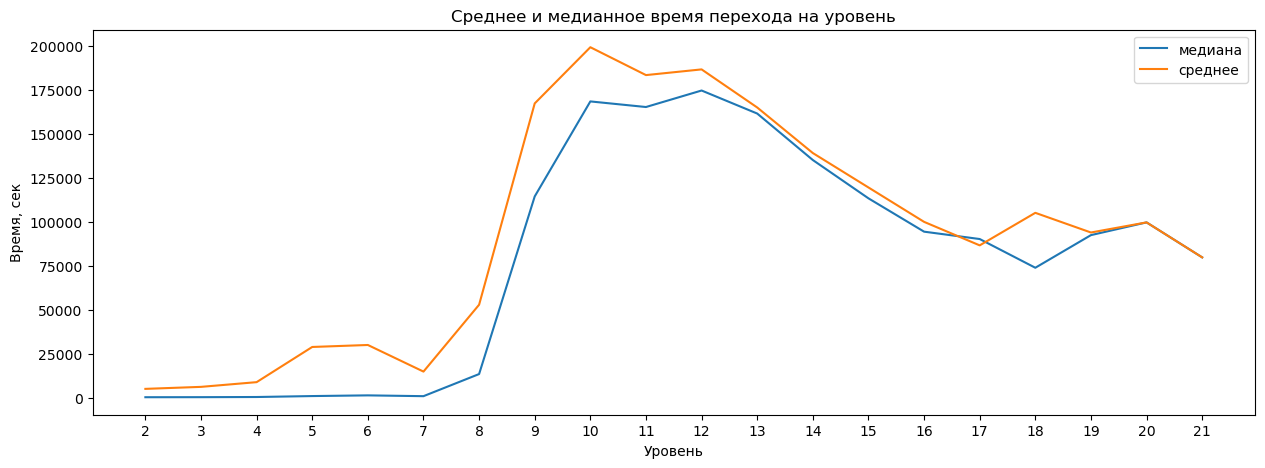

In [83]:
plt.figure(figsize=(15, 5))
time_per_level['median'].plot(kind='line')
time_per_level['mean'].plot(kind='line')

plt.title('Среднее и медианное время перехода на уровень')
plt.xlabel('Уровень')
plt.ylabel('Время, сек')
plt.legend(['медиана', 'среднее'])
plt.xticks(np.arange(2, 22))
plt.show();

**Промежуточный вывод**

Медианное и среднее время перехода на уровни имеют схожую динамику за исключением нескольких отрезков. Начиная с 7 уровня, время на прохождение возрастает. По-видимому, это связано с возрастанием сложности или потерей мотивации. После 12 уровня начинается спад.

Больше всего времени нужно, чтобы пройти 8, 9, 10, 11 уровни.

### Retention Rate

In [84]:
retention_table = users.merge(sessions[['user_id', 'open_time']], on='user_id')
retention_table

,user_id,reg_time,open_time
0,439127,2023-05-16 15:47:56,2023-05-16 15:47:56
1,439127,2023-05-16 15:47:56,2023-05-17 02:16:58
2,439127,2023-05-16 15:47:56,2023-05-17 03:18:01
3,439127,2023-05-16 15:47:56,2023-05-17 04:25:57
4,439127,2023-05-16 15:47:56,2023-05-17 10:22:22
...,...,...,...
355351,740216,2023-05-20 08:49:46,2023-05-29 14:24:10
355352,740216,2023-05-20 08:49:46,2023-05-29 14:54:39
355353,740216,2023-05-20 08:49:46,2023-05-29 20:22:48
355354,141306,2023-05-20 14:50:20,2023-05-20 14:50:20


In [85]:
retention_table['lifetime'] = (retention_table['open_time'].dt.date - retention_table['reg_time'].dt.date).dt.days
retention_table.sort_values(by='lifetime')

,user_id,reg_time,open_time,lifetime
27925,622739,2023-05-17 03:22:17,2023-05-16 02:05:38,-1
0,439127,2023-05-16 15:47:56,2023-05-16 15:47:56,0
75748,39354,2023-05-13 06:22:38,2023-05-13 06:22:38,0
75737,516629,2023-05-12 21:44:37,2023-05-12 23:53:58,0
75736,516629,2023-05-12 21:44:37,2023-05-12 21:44:37,0
...,...,...,...,...
19163,276420,2023-05-16 16:46:53,2023-05-26 03:11:50,10
19164,276420,2023-05-16 16:46:53,2023-05-26 06:48:28,10
300312,902514,2023-05-19 20:18:22,2023-05-29 04:40:58,10
300315,902514,2023-05-19 20:18:22,2023-05-29 11:14:48,10


In [86]:
retention_table.query('lifetime < 0')

,user_id,reg_time,open_time,lifetime
27925,622739,2023-05-17 03:22:17,2023-05-16 02:05:38,-1


In [87]:
retention_table = retention_table.query('lifetime >= 0')

In [88]:
retention_table['dt'] = retention_table['reg_time'].dt.date

In [89]:
retention_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355355 entries, 0 to 355355
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    355355 non-null  int64         
 1   reg_time   355355 non-null  datetime64[ns]
 2   open_time  355355 non-null  datetime64[ns]
 3   lifetime   355355 non-null  int64         
 4   dt         355355 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 16.3+ MB


Посмотрим, как ведут себя пользователи, зарегистрировавшиеся в разные дни:

In [90]:
retention_pivot = retention_table.pivot_table(index='dt', columns='lifetime', values='user_id', aggfunc='nunique')
retention_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10
dt,,,,,,,,,,,
2023-05-11,341.0,156.0,128.0,104.0,92.0,79.0,83.0,82.0,73.0,65.0,20.0
2023-05-12,397.0,181.0,141.0,117.0,91.0,95.0,89.0,85.0,74.0,64.0,28.0
2023-05-13,536.0,221.0,167.0,148.0,130.0,113.0,109.0,99.0,99.0,89.0,33.0
2023-05-14,1178.0,365.0,257.0,240.0,210.0,197.0,189.0,189.0,148.0,143.0,54.0
2023-05-15,3921.0,1377.0,1022.0,869.0,749.0,698.0,649.0,607.0,571.0,544.0,297.0
2023-05-16,8144.0,2701.0,1983.0,1689.0,1512.0,1350.0,1262.0,1199.0,1179.0,1104.0,310.0
2023-05-17,7094.0,3398.0,2626.0,2247.0,2005.0,1841.0,1694.0,1658.0,1546.0,1457.0,518.0
2023-05-18,5387.0,2771.0,2191.0,1929.0,1686.0,1530.0,1444.0,1411.0,1348.0,1219.0,196.0
2023-05-19,1574.0,736.0,599.0,522.0,451.0,458.0,421.0,405.0,358.0,333.0,129.0


In [91]:
retention_pivot_daily = retention_pivot.div(retention_pivot[0], axis=0)
retention_pivot_daily

lifetime,0,1,2,3,4,5,6,7,8,9,10
dt,,,,,,,,,,,
2023-05-11,1.0,0.457478,0.375367,0.304985,0.269795,0.231672,0.243402,0.240469,0.214076,0.190616,0.058651
2023-05-12,1.0,0.455919,0.355164,0.294710,0.229219,0.239295,0.224181,0.214106,0.186398,0.161209,0.070529
2023-05-13,1.0,0.412313,0.311567,0.276119,0.242537,0.210821,0.203358,0.184701,0.184701,0.166045,0.061567
2023-05-14,1.0,0.309847,0.218166,0.203735,0.178268,0.167233,0.160441,0.160441,0.125637,0.121392,0.045840
2023-05-15,1.0,0.351186,0.260648,0.221627,0.191023,0.178016,0.165519,0.154807,0.145626,0.138740,0.075746
2023-05-16,1.0,0.331655,0.243492,0.207392,0.185658,0.165766,0.154961,0.147225,0.144769,0.135560,0.038065
2023-05-17,1.0,0.478996,0.370172,0.316747,0.282633,0.259515,0.238793,0.233719,0.217931,0.205385,0.073019
2023-05-18,1.0,0.514386,0.406720,0.358084,0.312976,0.284017,0.268053,0.261927,0.250232,0.226286,0.036384
2023-05-19,1.0,0.467598,0.380559,0.331639,0.286531,0.290978,0.267471,0.257306,0.227446,0.211563,0.081957


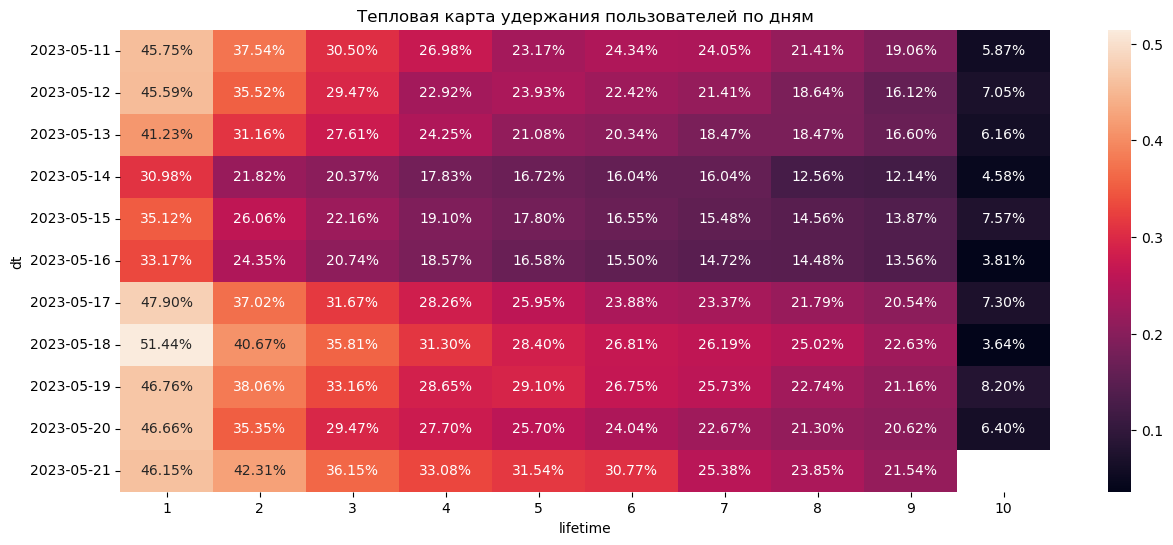

In [92]:
plt.figure(figsize=(15, 6)) 
sns.heatmap(
    retention_pivot_daily.drop(columns=[0]),  
    annot=True,  
    fmt='.2%',  
)
plt.title('Тепловая карта удержания пользователей по дням')  
plt.show()

Качественно пользователи с датой регистрации 14-16 мая (воскресенье-вторник) очевидно хуже остальных. У них существенно ниже возвращаемость, начиная с первого дня.

В целом показатели хорошие - даже на 9 день DAU в половине случаев примерно равен 20%, что считается хорошим показателем вовлеченности.

Посчитаем retention rate для всей когорты:

In [93]:
retention_cohort = retention_pivot.sum()
retention_cohort

lifetime
0     30453.0
1     12783.0
2      9788.0
3      8428.0
4      7454.0
5      6852.0
6      6401.0
7      6165.0
8      5800.0
9      5407.0
10     1697.0
dtype: float64

In [94]:
retention_rate = (retention_cohort.div(retention_cohort[0], axis=0) * 100).round(2)
retention_rate

lifetime
0     100.00
1      41.98
2      32.14
3      27.68
4      24.48
5      22.50
6      21.02
7      20.24
8      19.05
9      17.76
10      5.57
dtype: float64

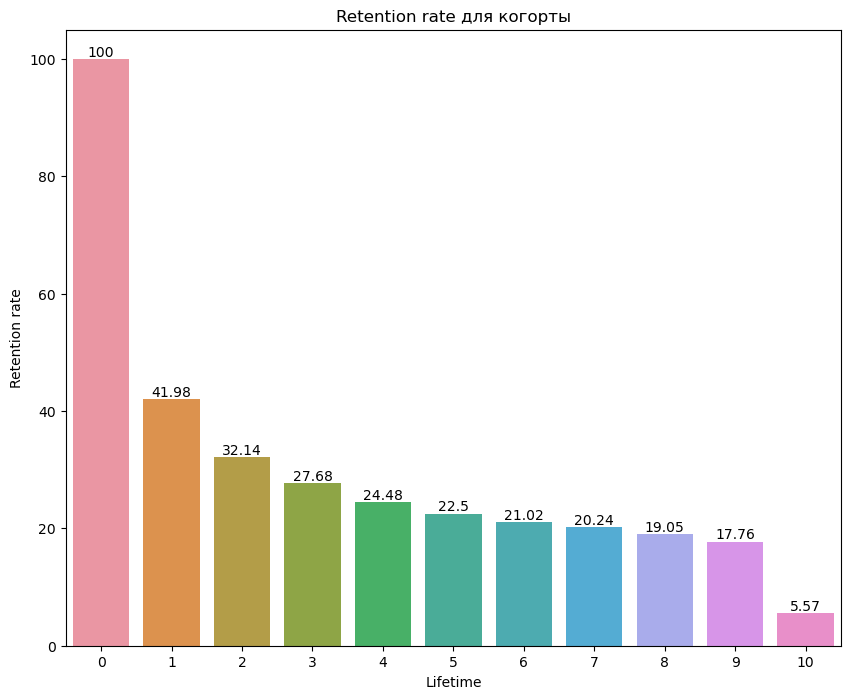

In [95]:
plt.figure(figsize=(10, 8))
ax = sns.barplot(y=retention_rate, x=retention_rate.index)

plt.title('Retention rate для когорты')
plt.xlabel('Lifetime')
plt.ylabel('Retention rate')
for i in ax.containers:
    ax.bar_label(i,)
plt.show();

**Промежуточный вывод**

Возвращаемость пользователей, зарегистрированных в разные дни неоднородна - наихудшие показатели у юзеров с регистрацией 14-16 мая.

В целом Retention Rate довольно неплохой - на второй день возвращается почти половина пользователей. Резкое падение есть на 10 день, однако эти данные не вполне достоверны, так как не все пользователи успели прожить десятидневный лайфтайм.

### Где пользователи совершают больше всего платежей?

In [96]:
buyers = payments.merge(levels, on='user_id', how='left')     
buyers

,user_id,pay_time,amt,time,level
0,107907,2023-05-29 17:08:18,0.400218,2023-05-20 20:25:29,2
1,107907,2023-05-29 17:08:18,0.400218,2023-05-20 20:30:14,3
2,107907,2023-05-29 17:08:18,0.400218,2023-05-20 20:36:57,4
3,107907,2023-05-29 17:08:18,0.400218,2023-05-21 16:36:11,5
4,107907,2023-05-29 17:08:18,0.400218,2023-05-26 17:04:26,6
...,...,...,...,...,...
7433,403762,2023-05-18 11:35:46,0.199608,2023-05-18 11:34:30,5
7434,403762,2023-05-18 11:35:46,0.199608,2023-05-18 11:47:00,6
7435,403762,2023-05-18 11:35:46,0.199608,2023-05-18 11:56:53,7
7436,403762,2023-05-18 11:35:46,0.199608,2023-05-18 12:18:01,8


In [97]:
buyers.query('user_id == 107907')

,user_id,pay_time,amt,time,level
0,107907,2023-05-29 17:08:18,0.400218,2023-05-20 20:25:29,2
1,107907,2023-05-29 17:08:18,0.400218,2023-05-20 20:30:14,3
2,107907,2023-05-29 17:08:18,0.400218,2023-05-20 20:36:57,4
3,107907,2023-05-29 17:08:18,0.400218,2023-05-21 16:36:11,5
4,107907,2023-05-29 17:08:18,0.400218,2023-05-26 17:04:26,6
5,107907,2023-05-29 17:08:18,0.400218,2023-05-26 17:20:43,7
6,107907,2023-05-29 17:08:18,0.400218,2023-05-26 20:16:36,8
7,107907,2023-05-29 17:08:18,0.400218,2023-05-28 11:17:57,9


In [98]:
buyers.query('user_id == 403762')

,user_id,pay_time,amt,time,level
7430,403762,2023-05-18 11:35:46,0.199608,2023-05-18 04:13:29,2
7431,403762,2023-05-18 11:35:46,0.199608,2023-05-18 08:11:34,3
7432,403762,2023-05-18 11:35:46,0.199608,2023-05-18 08:16:44,4
7433,403762,2023-05-18 11:35:46,0.199608,2023-05-18 11:34:30,5
7434,403762,2023-05-18 11:35:46,0.199608,2023-05-18 11:47:00,6
7435,403762,2023-05-18 11:35:46,0.199608,2023-05-18 11:56:53,7
7436,403762,2023-05-18 11:35:46,0.199608,2023-05-18 12:18:01,8
7437,403762,2023-05-18 11:35:46,0.199608,2023-05-20 04:05:51,9


In [99]:
buyers['nearest'] = (buyers['time'] - buyers['pay_time']).dt.total_seconds()
buyers = buyers.query('nearest > 0')
buyers

,user_id,pay_time,amt,time,level,nearest
14,510991,2023-05-20 16:55:01,0.199608,2023-05-20 19:58:12,8,10991.0
15,510991,2023-05-20 16:55:01,0.199608,2023-05-21 18:20:28,9,91527.0
16,510991,2023-05-20 16:55:01,0.199608,2023-05-26 19:10:43,10,526542.0
22,294837,2023-05-19 01:41:55,0.199608,2023-05-19 04:31:04,7,10149.0
23,294837,2023-05-19 01:41:55,0.199608,2023-05-19 04:41:00,8,10745.0
...,...,...,...,...,...,...
7422,895621,2023-05-22 20:50:28,3.008157,2023-05-23 00:24:56,8,12868.0
7434,403762,2023-05-18 11:35:46,0.199608,2023-05-18 11:47:00,6,674.0
7435,403762,2023-05-18 11:35:46,0.199608,2023-05-18 11:56:53,7,1267.0
7436,403762,2023-05-18 11:35:46,0.199608,2023-05-18 12:18:01,8,2535.0


In [100]:
nearest_payment = buyers.groupby(['user_id', 'pay_time', 'amt'])['nearest'].agg('min').reset_index()
nearest_payment

,user_id,pay_time,amt,nearest
0,199,2023-05-22 20:32:31,0.199608,596.0
1,199,2023-05-25 06:09:40,1.503577,59262.0
2,199,2023-05-25 06:30:46,1.002050,57996.0
3,2586,2023-05-22 15:57:31,0.199608,8338.0
4,2586,2023-05-27 05:33:25,0.400218,36243.0
...,...,...,...,...
605,996919,2023-05-21 11:47:07,0.400218,3864.0
606,996919,2023-05-27 19:27:15,0.400218,50331.0
607,997704,2023-05-21 11:19:27,0.400218,19098.0
608,997704,2023-05-22 09:58:57,0.400218,15748.0


In [101]:
buyers = nearest_payment.merge(buyers, on=['user_id', 'pay_time', 'amt', 'nearest'])
buyers['level'] = buyers['level'] - 1
buyers.rename(columns={'level':'current_level'}, inplace=True)
buyers

,user_id,pay_time,amt,nearest,time,current_level
0,199,2023-05-22 20:32:31,0.199608,596.0,2023-05-22 20:42:27,5
1,199,2023-05-25 06:09:40,1.503577,59262.0,2023-05-25 22:37:22,9
2,199,2023-05-25 06:30:46,1.002050,57996.0,2023-05-25 22:37:22,9
3,2586,2023-05-22 15:57:31,0.199608,8338.0,2023-05-22 18:16:29,6
4,2586,2023-05-27 05:33:25,0.400218,36243.0,2023-05-27 15:37:28,9
...,...,...,...,...,...,...
605,996919,2023-05-21 11:47:07,0.400218,3864.0,2023-05-21 12:51:31,9
606,996919,2023-05-27 19:27:15,0.400218,50331.0,2023-05-28 09:26:06,11
607,997704,2023-05-21 11:19:27,0.400218,19098.0,2023-05-21 16:37:45,10
608,997704,2023-05-22 09:58:57,0.400218,15748.0,2023-05-22 14:21:25,11


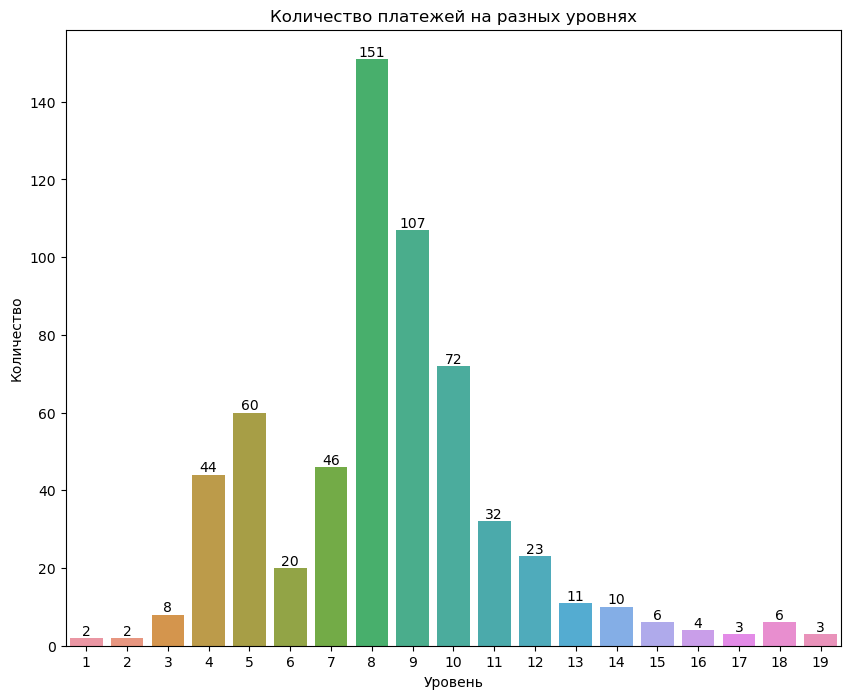

In [102]:
plt.figure(figsize=(10, 8))
ax = sns.countplot(data=buyers, x='current_level')
plt.title('Количество платежей на разных уровнях')
plt.xlabel('Уровень')
plt.ylabel('Количество')
for i in ax.containers:
    ax.bar_label(i,)
plt.show();

Больше всего платежей на 8, 9 и 10 уровнях. Что подтверждает сделанные раннее выводы о возросшей сложности заданий.

In [103]:
buyers[['current_level', 'amt']].describe()

,current_level,amt
count,610.000000,610.000000
mean,8.393443,0.705050
std,2.890325,1.024404
min,1.000000,0.099302
25%,7.000000,0.199608
50%,8.000000,0.400218
75%,10.000000,0.400218
max,19.000000,10.029531


<Figure size 1000x1000 with 0 Axes>

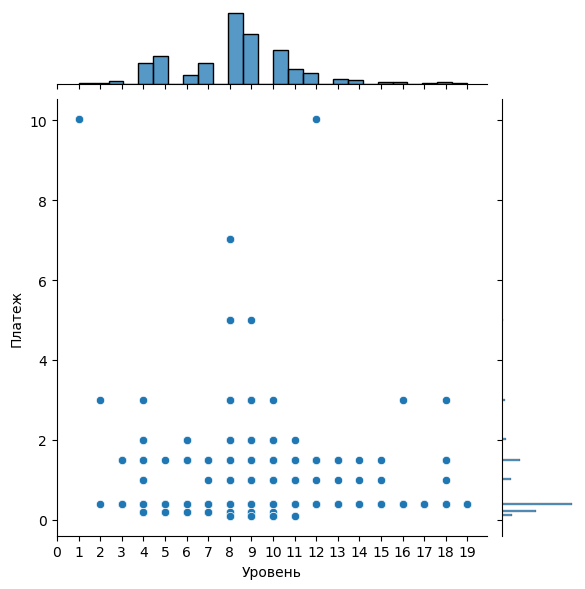

In [104]:
plt.figure(figsize=(10, 10))
sns.jointplot(data=buyers, x='current_level', y='amt')

# plt.title('Распределение платежей на разных уровнях')
plt.xlabel('Уровень')
plt.ylabel('Платеж')
plt.xticks(np.arange(0, 20))
plt.show();

Большая часть платежей составляет 0.400218 доллара, такая сумма присутствует на всех уровнях. Более крупные платежи встречаются на более высоких уровнях.

In [105]:
buyers.query('amt > 0.400218')['current_level'].value_counts()

8     95
9     83
10    68
4     39
11    30
12    23
7     18
5     13
13    11
14    10
3      8
6      8
15     6
18     6
16     4
17     3
19     3
1      2
2      2
Name: current_level, dtype: int64

In [106]:
buyers.query('amt > 0.400218 and current_level <= 2')

,user_id,pay_time,amt,nearest,time,current_level
56,105269,2023-05-19 19:28:20,0.400218,157.0,2023-05-19 19:30:57,2
432,759639,2023-05-15 16:12:06,10.029531,29.0,2023-05-15 16:12:35,1
433,759639,2023-05-15 16:12:26,10.029531,9.0,2023-05-15 16:12:35,1
527,898360,2023-05-20 21:22:01,3.008157,347.0,2023-05-20 21:27:48,2


Пользователь с id 759639 сделал два крупных платежа по 10$ на первом уровне. Изучим его поведение:

In [107]:
payments.query('user_id == 759639')

,user_id,pay_time,amt
252,759639,2023-05-15 16:12:06,10.029531
253,759639,2023-05-15 16:12:26,10.029531
254,759639,2023-05-15 16:38:18,5.014264
255,759639,2023-05-15 16:46:40,7.019368
256,759639,2023-05-15 18:16:49,10.029531
257,759639,2023-05-15 19:43:30,10.029531


In [108]:
levels.query('user_id == 759639')

,user_id,time,level
90257,759639,2023-05-15 16:12:35,2
90258,759639,2023-05-15 16:14:14,3
90259,759639,2023-05-15 16:16:21,4
90260,759639,2023-05-15 16:21:06,5
90261,759639,2023-05-15 16:24:32,6
90262,759639,2023-05-15 16:29:40,7
90263,759639,2023-05-15 16:35:11,8
90264,759639,2023-05-15 17:02:29,9
90265,759639,2023-05-15 17:10:54,10
90266,759639,2023-05-15 17:30:03,11


In [109]:
sessions.query('user_id == 759639')

,user_id,close_time,open_time,session_duration
254494,759639,2023-05-15 05:11:10,2023-05-15 03:30:02,6068.0
263126,759639,2023-05-15 20:06:14,2023-05-15 16:10:10,14164.0


In [110]:
users.query('user_id == 759639')

,user_id,reg_time
10691,759639,2023-05-15 03:30:02


In [111]:
payments['amt'].sum()

501.4063511450382

Пользователь потратил 52 доллара, что составляет почти 10% от всех платежей за исследуемый период. За две сессии длительностью чуть меньше 2 и 4 часов дошел до 14 уровня, а затем перестал заходить в приложение. Возможно, команде стоит подумать о том, чтобы немного снизить сложность высоких уровней. Не настолько, чтобы люди перестали платить, но настолько, чтобы продолжали играть.

**Промежуточный вывод**

Больше всего платежей на 8, 9 и 10 уровнях. Что подтверждает сделанные раннее выводы о возросшей сложности заданий. Большая часть платежей составляет 0.400218 доллара (75 процентиль), такая сумма присутствует практически на всех уровнях. Более крупные платежи также в основном приходятся на 8, 9 и 10 уровни. Хотя на 1 и 2 уровне были сделаны по два платежа и все они были крупные.

### Где ученики совершают первые платежи?

In [112]:
first_payment = buyers.groupby('user_id').agg(first_payment=('current_level', 'min'))
first_payment

,first_payment
user_id,
199,5
2586,6
4609,9
6500,5
6906,8
...,...
980211,9
986290,5
990983,8


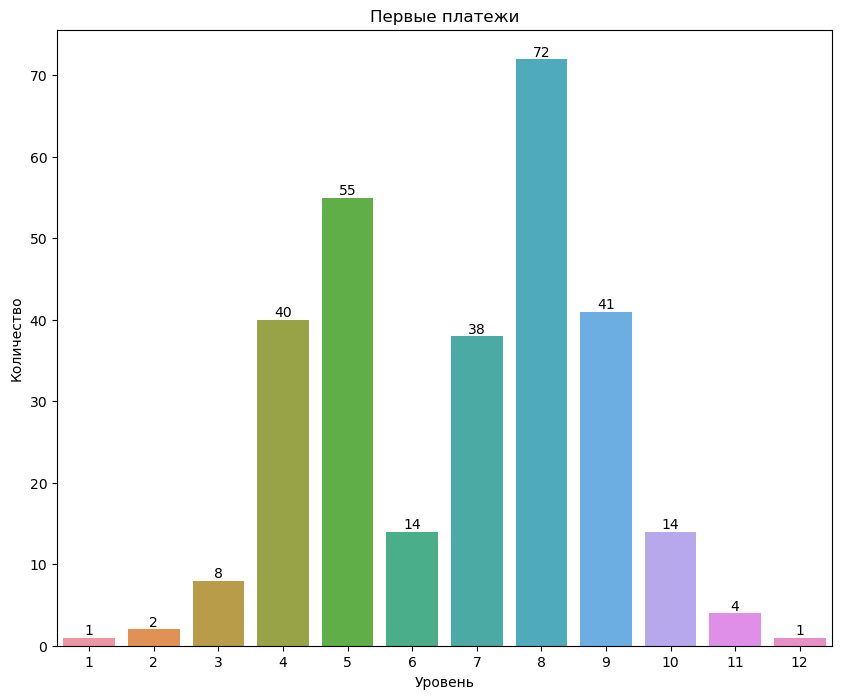

In [113]:
plt.figure(figsize=(10, 8))
ax = sns.countplot(data=first_payment, x='first_payment')
plt.title('Первые платежи')
plt.xlabel('Уровень')
plt.ylabel('Количество')
for i in ax.containers:
    ax.bar_label(i,)
plt.show();

In [114]:
levels.query('level > 12')

,user_id,time,level
235,400737,2023-05-25 11:17:05,13
282,165812,2023-05-26 02:34:04,13
743,675760,2023-05-23 10:31:22,13
972,50915,2023-05-17 03:36:52,13
973,50915,2023-05-18 06:08:01,14
...,...,...,...
130549,778687,2023-05-23 03:35:46,14
130550,778687,2023-05-24 09:31:38,15
130551,778687,2023-05-26 07:35:14,16
130552,778687,2023-05-27 13:31:18,17


Больше всего игроков впервые платит на 8-м уровне. Второй по величине по количеству первых платежей - 5-ый уровень.

После 12 уровня пользователи перестают делать платежи, а это 1463 пользователя. Возможно, сложность возрастает настолько, что у игроков пропадает мотивация.

### Метрики монетизации для всей когорты

#### Средний чек

Посчитаем средний чек по формуле Average Price = Revenue / Orders

In [115]:
average_рrice = payments['amt'].sum() / payments.shape[0]
print(f'Средний чек: {average_рrice.round(2)}$')

Средний чек: 0.72$


#### Среднее число покупок

Формула: APC = Orders / Buyers

In [116]:
apc = payments.shape[0] / payments['user_id'].nunique()
print(f'Среднее число покупок: {round(apc, 2)}')

Среднее число покупок: 2.24


#### ARPPU - средний доход с покупателя

ARPPU = APC × Average Price

In [117]:
arppu = apc * average_рrice
print(f'Средний доход с покупателя: {round(arppu, 2)}')

Средний доход с покупателя: 1.61


#### ARPU - средний доход с пользователя

ARPU = Revenue / User Acq

In [118]:
arpu = payments['amt'].sum() / users['user_id'].nunique()
print(f'Средний доход с пользователя: {round(arpu, 2)}')

Средний доход с пользователя: 0.02


#### Конверсия

C = Buyers / User Acq

In [119]:
payments['user_id'].nunique() / users['user_id'].nunique()

0.0100418410041841

Проверим себя по другой формуле:

С = ARPU / ARPPU

In [120]:
print(f'Конверсия: {round(arpu / arppu, 2)}')

Конверсия: 0.01


## Выводы

Когорта представляет собой 31 144 пользователя, зарегистрировавшихся в приложении 11-21 мая 2023 года.

Период исследования: 11-30 мая 2023 года.

**Наблюдения и выводы:**
- 44 пользователя не совершили ни одного действия,
- 5 525 пользователей не поднялись выше 1 уровня, 
- лишь 25% пользователей поднялись выше 7-го уровня,
- из 31 070 пользователей всего лишь 312 покупателей,
- общее число платежей - 699 платежей, 674 из них не превышают 2.1$,
- в логах видны "проплешины", приложение довольно часто имеет проблемы с доступностью,
- 2648 сессий имеют длительность 0 секунд, скорее всего это связано с техническими проблемами,
- среднее время сессии составляет 683 секунды (около 11 минут), а медианное - 417 секунд (примерно 7 минут),
- в логах больше 2 тысяч сессий короче 10 секунд; возможно, пользователи заходят в приложение, чтобы было зафиксировано ежедневное посещение, например, с целью получить бонусы,
- начиная с 7 уровня медианное и среднее время прохождения уровня резко возрастают, небольшой спад начинается после 12 уровня
- максимальное среднее время прохождения уровня - 55 с половиной часов (9 уровень),
- в целом Retention Rate довольно неплохой - на второй день возвращается почти половина пользователей, на 9 день DAU в среднем равно 20%,
- качественно пользователи с датой регистрации 14-16 мая (воскресенье-вторник) очевидно хуже остальных, у них существенно ниже возвращаемость, начиная с первого дня,
- больше всего платежей на 8, 9 и 10 уровнях,
- большая часть платежей составляет 0.400218 доллара (75 процентиль), такая сумма присутствует практически на всех уровнях; более крупные платежи также в основном приходятся на 8, 9 и 10 уровни,
- после 12 уровня пользователи перестают делать платежи, а это 1463 пользователя; возможно, сложность возрастает настолько, что у игроков пропадает мотивация.

**Метрики монетизации для когорты:**

- Средний чек: 0.72$

- Среднее число покупок: 2.24

- Средний доход с покупателя: 1.61

- Средний доход с пользователя: 0.02

- Конверсия: 1%

**Очень низкая конверсия и ARPU.**

## Рекомендации

1. Устранить перебои в работе приложения.
2. Собрать данные о рекламных расходах (Marketing Costs).
3. Посчитать стоимость привлечения покупателя CAC (CAC = Marketing Costs / Buyers) и стоимость привлечения пользователя CPA (CPAcq = Marketing Costs / User Acq).
4. Рассчитать ROI - возврат на инвестиции.
5. Возможно, команде стоит подумать о том, чтобы немного снизить сложность высоких уровней. Не настолько, чтобы люди перестали платить, но настолько, чтобы продолжали играть.

## Ответы на дополнительные вопросы

### Вопрос №1

**Вопрос:** В результате изменений в продукте ARPPU снизился. Это хорошо или плохо? 

**Ответ:** **ARPPU** (Average Revenue per Paying User) - это средний доход с платящего пользователя за определенный период, как правило, месяц. Вычисляется по следующей формуле:
                                    
                            ARPPU = Revenue / Paying users
                                    
Снижение ARPPU в краткосрочной перспективе не означает ничего плохого. Это может быть связано с большим притоком новых плательщиков, совершивших пока всего одну покупку. Если они перейдут в разряд постоянных пользователей и будут совершать повторные покупки, показатель снова вырастет.

Более точные выводы можно сделать, проверив средний чек. Если он не изменился, значит, все дело в уменьшении APC (Average Payment Count) - среднем числе покупок на одного платящего пользователя. Этот показатель выровняется, когда новые пользователи начнут совершать повторные покупки.

                            ARPPU = APC * Average Price        
                            APC = Orders / Buyers

### Вопрос №2

**Вопрос:** Предположим, что в результате обновления дизайна продукта вы наблюдаете увеличение среднего времени нахождения пользователей в приложении, но уровень конверсии в покупку снизился. Как вы будете анализировать данное изменение и какие рекомендации вы предложите команде продукта?

**Ответ:** Возможно, изменения в дизайне вызвали сложности с навигацией или функционированием приложения, и пользователям приходится тратить больше времени. Возможно, после изменений возникли трудности с оплатой, например, не работает кнопка или невозможно провести платеж. Чтобы понять, что происходит, надо определить, вызвано ли снижение конверсии уменьшением числа плательщиков или резким увеличением количества новых пользователей.

Если к снижению конверсии привело резкое увеличение числа новых пользователей, которые разбираются с приложением (что увеличивает время пользования продуктом), но пока ничего не покупают, команде продукта нужно просто подождать.

В противном случае, вероятно наличие проблем с версткой или, например, эквайрингом. Тогда команде следует провести техническую экспертизу, чтобы выявить и устранить проблемы. Возможно, локализовать проблему поможет анализ продуктовой воронки. Если на каком-то шаге конверсия существенно уменьшилась, значит, проблему нужно искать в этом разделе.

Если технических проблем нет, возможно, пользователям просто не нравится новый дизайн, как было с неудачным обновлением Кинопоиска в 2015 году. Команде придется рассмотреть вопрос отката на старую версию. 